In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 36, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Hp\AppData\Local\Temp\pip-install-6dqd2zka\tensorflow-gpu_d641f19cffc74dafad1a4b77baaad69b\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not r

In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [8]:
pwd

'C:\\Users\\Hp'

In [9]:
df = pd.read_csv("train.csv")

In [10]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
altair                       4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astunparse                   1.6.3
attrs                        21.4.0
auth-token                   0.0.3
backcall                     0.2.0
backports.zoneinfo           0.2.1
beautifulsoup4               4.11.1
bleach                       5.0.1
blinker                      1.5
cachetools                   5.2.0
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
click                        8.1.3
cloudpickle                  2.2.1
colorama                     0.4.5
commonmark                   0.9.1
customtkinter                4.6.3
cvlib                        0.2.7
cycler                       0.11.0
darkdetect                   0.8.0
debugpy                      1.6.2
decorator                    5.1.1
defu

In [12]:
from tensorflow.keras.layers import TextVectorization

In [13]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [14]:
MAX_FEATURES = 200000

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [16]:

vectorizer.adapt(X.values)


In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [19]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [24]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 9005s 1s/step - loss: 0.0631 - val_loss: 0.0482


In [25]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

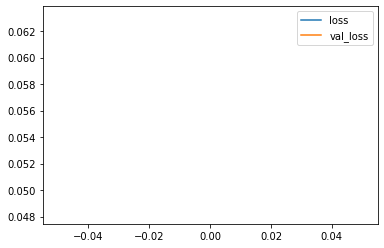

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [29]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [31]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 0s 79ms/step


In [32]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [33]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [34]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 147ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
res.shape

(1, 6)

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 157ms/step


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.832335352897644, Recall:0.6714975833892822, Accuracy:0.46439316868782043


In [40]:
!pip install gradio jinja2

     ---------------------------------------- 14.2/14.2 MB 2.0 MB/s eta 0:00:00
     ------------------------------------ 101.4/101.4 kB 970.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 322.2/322.2 kB 398.9 kB/s eta 0:00:00
     -------------------------------------- 56.9/56.9 kB 501.5 kB/s eta 0:00:00
     -------------------------------------- 195.5/195.5 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 71.5/71.5 kB 651.4 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 84.5/84.5 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.1/2.1 MB 1.2 MB/s eta 0:00:00
     -------------------------------------- 56.2/56.2 kB 589.7 kB/s eta 0:00:00


In [41]:
import tensorflow as tf
import gradio as gr

In [42]:
model.save('toxic comment.h5')

In [45]:
model = tf.keras.models.load_model('toxic comment.h5')

In [46]:
input_str = vectorizer('hey i freaken hate you!')


In [47]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 3s 3s/step


In [48]:
res

array([[0.69226587, 0.01138315, 0.28151587, 0.01282657, 0.25036395,
        0.03607646]], dtype=float32)

In [51]:
df.columns[2:-1]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult'], dtype='object')

In [52]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [53]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

c:\python37\lib\site-packages\gradio\inputs.py:28: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
c:\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [54]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link, please check your internet connection.


1/1 [==============================] - 0s 82ms/step
